# Project 5 - Text Analysis - FINAL

## Sophie Wu

## 1. Brief

**[Potential use of findings / project motivation]** <br>
UBS's Global Research department makes stock recommendations based on company and sector fundamental analysis. Europe Food Retailers is a sector covered by the department with combined market capitalisation >EUR100bn. Consumer perception is a leading indicator for food retailers' top line performance. Public voice opinions on social media platforms such as Twitter to express satisfaction/disatisfaction. Sentiment analysis of tweets can be a proxy for consumer perception and help Analysts in Global Research to forecast and predict food retailers' trading; and thus improving quality of Analysts' stock recommendations. The department currently have a 'Buy' recommendation on Tesco PLC. In addition to gauging the average sentiment, it would be useful to also classify tweets based on sentiments, such that we can isolate all tweets of negative sentiment for example for further analysis (e.g. topic or content analysis to inform Analysts potential problem areas the company's management would need to address for operational turnaround.


**[Data questions]** <br>
With the above in mind, this data analysis project aims to achieve the below:<br>
1) Assess consumer perception (positive or negative sentiment) towards Tesco through text sentiment analysis of tweets. Our null hypothesis is that on average sentiment towards Tesco is positive (given the company has implemented several initiatives to improve loyalty and price perception).<br>
2) We assess whether tweets are easily classifiable based on their sentiment. We define easily classifiable as having an accuracy >0.7 and F1 score for negative sentiment > 0.7 (we care particularly about the model's ability to capture all negative sentiments - not addressing customer disatisfaction can be detrimental to sales and business performance).
  
This data analysis project is split into two sections, separately answering data questions #1 and #2.



## 2. Load libraries

In [4]:
# for data and matrix manipulation
import pandas as pd
import numpy as np

# for data visualisation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud
from sklearn.decomposition import PCA, TruncatedSVD

# for string manipulation
import re
import string

# for text pre-processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# necessary dependencies from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# for assigning sentiment polarity scores
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# for extracting features -- i.e. the DT matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

# for splitting the data into a training and a testing set
from sklearn.model_selection import train_test_split

# algorithms for classification analysis
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

# for evaluating our machine learning model
from sklearn.metrics import accuracy_score, classification_report

# for writing csv files
import csv

###########################
#For accessing Twitter API#
###########################

# import necessary methods from tweepy library
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener

# variables containing credentials to acccess Twitter API
access_token = "4329631636-sZda9YIKPdRbQAICrGpV8KdrMwaicSpMCtau0qC"
access_token_secret = "YAzNrZ1t2GwgOh3XET5alI2yNchlIMa1ou4SqrKlxFa5z"
consumer_key = "eg0JJjYzI61M0cYX7iJAmk13k"
consumer_secret = "9l1dr7mrscRZFg2DMlS7gELz6YXoHVZolPzlINhosR0C0E63hb"

# pass Twitter credentials to Tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/SophieMQWu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SophieMQWu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SophieMQWu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3. Data sourcing - extracting tweets with reference to 'Tesco'

**[Sourcing the relevant data]** <br>
- We will extract tweets from Twitter using the `tweepy` library to access the Twitter API.  
- We get tweets from Twitter created between *'2019-11-14'* and *'2019-11-15'* using Tweepy and store the data as a csv file*. note: with *api.search*, only tweets from the last 7 days can be accessed. We restrict the timeframe to only 1 day due to limitations of computing power. <br>
- We search for tweets with of either `@tesco` or `#tesco`.<br>
- We exclude retweets and only focus on tweets written in the English language. <br>
- We are interested in the *'text'* attribute of tweet data and call for `tweet.text`. 
- We extract whole tweets instead of default truncated texts and call for argument `tweet_mode = "extended"`

**[Data sharing guidelines]**<br>
To access Twitter APIs, users are required to register an application which can only access public information on Twitter (i.e. tweets). Tweets are public and do not involve data sharing concerns. 

In [ ]:
# collect tweets

csvFile = open('tesco_tweets.csv', 'a')
csvWriter = csv.writer(csvFile)

for tweet in tweepy.Cursor(api.search,
                           q = "@tesco OR #tesco -filter:retweets",
                           since = "2019-11-14",
                           until = "2019-11-15",
                           lang = "en",
                           tweet_mode = "extended").items():

# write a row to the csv file
    csvWriter.writerow([tweet.created_at, tweet.full_text])  
    print (tweet.created_at, tweet.full_text)
csvFile.close()

In [85]:
# read saved csv file
tesco_df = pd.read_csv("tesco_tweets.csv", header = None, 
                       names = ["date","text"] )
tesco_df.head()

,date,text
0,2019-11-14 23:50:31,@bbclaurak Can we nationalise @Tesco or @AldiU...
1,2019-11-14 23:49:59,@taracartergmc @mechanic_mrs @Morrisons @Tesc...
2,2019-11-14 23:39:51,@Tesco Scranning our lasses arse
3,2019-11-14 23:35:23,Dear @Tesco how come you can get #clubcard poi...
4,2019-11-14 23:34:54,My @Tesco delivery is late...booked a 7 - 11 s...


In [6]:
tesco_df.shape

(1002, 2)

In [7]:
# we are more interested in the 'text' feature of the tweets we have extracted 
# and not the datetime given we limited the tweets to be from only 14th Nov 2019.
tesco_tweets = tesco_df['text']
print(tesco_tweets[0:10])
type(tesco_tweets)

0    @bbclaurak Can we nationalise @Tesco or @AldiU...
1    @taracartergmc @mechanic_mrs @Morrisons  @Tesc...
2                     @Tesco Scranning our lasses arse
3    Dear @Tesco how come you can get #clubcard poi...
4    My @Tesco delivery is late...booked a 7 - 11 s...
5            @Tesco Discriminates against poor people.
6         Oh @Tesco that Casablanca ad is truly awful.
7    @Crackintosh_ @Tesco The pastry’s the best par...
8    @Tesco So basically if someone can't commit £7...
9    @Tesco These days I start my day with a peanut...
Name: text, dtype: object


pandas.core.series.Series

A total of 1002 tweets were extracted.

In [8]:
# we define a sample tweet which we can test with during data preprocessing stage 
# before applying the cleaning process to all tweets in the pandas Series object.
sample_tweet = tesco_df.iloc[0]['text']
sample_tweet = sample_tweet.lower()
sample_tweet

"@bbclaurak can we nationalise @tesco or @aldiuk, i'm fed up of always having to pay for my shopping."

## 4. [Data Question 1] - sentiment analysis

### 4.1 Data preprocessing

Before tokenising data for analysis, we clean the tweets.
- We remove special characters (punctuations, special characters and numericals).
- We normalise text to all lowercase
- We normalise text and convert apostrophed phrases to standard lexicon (otherwise tokenize will return words like `couldn't` as `couldn'` and `t` instead of `could` and `not`.
- We don't take onto consideration emojis in this analysis (TextBlob cannot handel emojis and emoticons).
- We don't correct for spelling mistakes. Functions e.g. `TextBlob().correct()` are able to make simple spelling corrections. However, as shown below, corrections are not always accurate, especially when dealing with proper nouns ('Tesco' was converted to 'test'). For our purpose it's not crucial to correct for spelling mistakes as we're looking  for the average sentiment towards Tesco, so effect of spelling errors should average out across all tweets.
- We normalise text by lemmatizing and stemming; returning words to their base. 

In [10]:
# why we don't correct for spelling errors using TextBlob().correct()
TextBlob(sample_tweet).correct()

TextBlob("@bbclaurak can we nationalism @test or @aldiuk, i'm fed up of always having to pay for my shopping.")

- 'nationalise' was incorrectly converted to 'nationalism'
- 'tesco' was incorrectly converted to 'test'

In [11]:
# Apostrophe dictionary. %load ./NLP/appos.py. 
# We load this dictionary for converting apostrophes to standard lexicon.
appos = {
"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not",
"didn't" : "did not", "doesn't" : "does not", "don't" : "do not",
"hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not",
"he'd" : "he would", "he'll" : "he will", "he's" : "he is",
"i'd" : "I would", "i'd" : "I had", "i'll" : "I will",
"i'm" : "I am", "isn't" : "is not", "it's" : "it is",
"it'll":"it will", "i've" : "I have", "let's" : "let us",
"mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not",
"she'd" : "she would", "she'll" : "she will", "she's" : "she is",
"shouldn't" : "should not", "that's" : "that is", "there's" : "there is",
"they'd" : "they would", "they'll" : "they will", "they're" : "they are",
"they've" : "they have", "we'd" : "we would", "we're" : "we are",
"weren't" : "were not", "we've" : "we have", "what'll" : "what will",
"what're" : "what are", "what's" : "what is", "what've" : "what have",
"where's" : "where is", "who'd" : "who would", "who'll" : "who will",
"who're" : "who are", "who's" : "who is", "who've" : "who have",
"won't" : "will not", "wouldn't" : "would not", "you'd" : "you would",
"you'll" : "you will", "you're" : "you are", "you've" : "you have",
"'re": " are", "wasn't": "was not", "we'll":" will", "didn't": "did not"
}


In [12]:
def clean_tweet(tweet):
    
    #################
    # NORMALISATION #
    #################
    
    # change everything to lower case
    tweet = tweet.lower()
    
    # converting apostrophes to standard lexicons
    # we use the re.split() method to break a string at each space and keeping apostrophed words together 
    # before converting apostrophed words to standard lexicon
    words = tweet.split()
    tweet = [appos[w] if w in appos else w for w in words]
    tweet = " ".join(tweet) 
    
    # stem words
    tweet = PorterStemmer().stem(tweet)
    
    # lemmatize words
    tweet = WordNetLemmatizer().lemmatize(tweet)
    
    ############
    # TOKENIZE #
    ############
    
    words = word_tokenize(tweet)
    
    # remove words that belong to the stopwords list from the NLTK corpus. stopwords are words like 'and', 'you', and 'I' 
    # that add little value to our model and would only clutter our corpus.
    # remove punctuations and special characters and numerical tokens which do not contribute to sentiment.
    words = [w for w in words if w not in stopwords.words('english') and w.isalpha()]
    
    # join list of words 
    text = ' '.join(words)
    
    return text

In [13]:
# we check if our function works using with some sample tweets.

for i in range(0,5):
    print("Original Text:" + tesco_df.iloc[i]['text'])
    print("Cleaned Text:" + clean_tweet(tesco_df.iloc[i]['text']))
    print("--------------")
    

Original Text:@bbclaurak Can we nationalise @Tesco or @AldiUK, I'm fed up of always having to pay for my shopping.
Cleaned Text:bbclaurak nationalise tesco aldiuk fed always pay shopping
--------------
Original Text:@taracartergmc @mechanic_mrs @Morrisons  @Tesco  @asda  you lot are missing a trick, get supplying your 20p-30p paracetamol to the NHS. You'll make money and save the tax payer £££££££
Cleaned Text:taracartergmc morrisons tesco asda lot missing trick get supplying paracetamol nhs make money save tax payer
--------------
Original Text:@Tesco Scranning our lasses arse
Cleaned Text:tesco scranning lasses ars
--------------
Original Text:Dear @Tesco how come you can get #clubcard points on booze but not on tobacco products (including Rizla) what are the morals of Tesco ?
Cleaned Text:dear tesco come get clubcard points booze tobacco products including rizla morals tesco
--------------
Original Text:My @Tesco delivery is late...booked a 7 - 11 slot and got one text saying it'll 

We see that cleaning the tweets can lose some meaning of the original sentence. 'fed up' (negative sentiment) became 'fed' and lost its original meaning.

In [14]:
tesco_tweets = tesco_tweets.apply(lambda x: clean_tweet(x))

In [15]:
tesco_tweets[0:10]

0    bbclaurak nationalise tesco aldiuk fed always ...
1    taracartergmc morrisons tesco asda lot missing...
2                           tesco scranning lasses ars
3    dear tesco come get clubcard points booze toba...
4    tesco delivery late booked slot got one text s...
5                      tesco discriminates poor people
6                   oh tesco casablanca ad truly awful
7                 tesco pastry best part stop complain
8    tesco basically someone commit month saying de...
9    tesco days start day peanut butter jam sandwic...
Name: text, dtype: object

### 4.2. Taking a look at the most common words (using BoWs) to get a sense of overall sentiment

We start with simplest model, BoW, which is a representation of text that describes the occurence of words within a document. Any information about the order or structure of words in the document is discarded. <br>
- We specify that we need no more than 10000 features -- i.e. 10000 unique terms. 

- We also specify the min_df parameter to be 0.01 (our terms should at least be used in 1% of our tweets.

- We set an ngram_range of (1,2). This means that we're only looking for words (length = 1), as well as bigrams(phrases). We ignore trigrams as trigrams that appear > 0.5% in the corpus are different combinations of the name of Tesco and its competitors (e.g. tesco, asda, morrisons) (see below)
- We set min_df = 0.005, through trial and error, this was set to a level such that words which appear like twitter account names are filtered out.

In [16]:
# Learn the vocabulary dictionary and return term-document matrix.
vector = CountVectorizer(max_features= 10000, min_df = 0.005, ngram_range= (1,2))

# We use the fit_transform() function to apply the above to our tweets. 
bag_of_words = vector.fit_transform(tesco_tweets)

bag_of_words

<1002x444 sparse matrix of type '<class 'numpy.int64'>'
	with 7083 stored elements in Compressed Sparse Row format>

This is a sparse matrix of:
- 1002 documents - i.e. tweets
- 444 unique terms <br>

Where each cell represents the number of times the term in question occurs in the document in question. <br> 

In [17]:
# looks like we've filtered out most twitter account names.
print(vector.get_feature_names()[0:100])

['able', 'absolutely', 'account', 'actually', 'ad', 'advert', 'ago', 'aldi', 'aldiuk', 'aldiuk tesco', 'almost', 'already', 'also', 'always', 'amazing', 'amp', 'another', 'answer', 'anymore', 'anyone', 'around', 'asda', 'asda morrisons', 'asda rspotweets', 'asked', 'assistant', 'available', 'away', 'awful', 'back', 'bad', 'bag', 'bags', 'bags help', 'bagsofhelp', 'beef', 'believe', 'best', 'better', 'big', 'biscuits', 'bit', 'bought', 'box', 'boxes', 'branch', 'brand', 'bread', 'buy', 'buying', 'called', 'campaign', 'cant', 'car', 'card', 'casablanca', 'change', 'check', 'checkout', 'cheese', 'chicken', 'children', 'chocolate', 'chrisgpackham', 'chrisgpackham greenpeaceuk', 'christmas', 'clear', 'click', 'close', 'closed', 'clubcard', 'collect', 'come', 'comes', 'complaint', 'contact', 'coopuk', 'could', 'couple', 'customer', 'customer assistant', 'customer service', 'customers', 'cut', 'date', 'day', 'days', 'dead', 'deal', 'delivered', 'delivery', 'different', 'discount', 'disgusting

In [18]:
# Bigrams
vector2 = CountVectorizer(max_features= 10000 , min_df=0.005, ngram_range= (2,2))
vector2.fit_transform(tesco_tweets)
print(vector2.get_feature_names())

['aldiuk tesco', 'asda morrisons', 'asda rspotweets', 'bags help', 'chrisgpackham greenpeaceuk', 'customer assistant', 'customer service', 'done tesco', 'fruit veg', 'gpukforests janegoodallinst', 'greenpeaceuk gpukforests', 'hey tesco', 'hi tesco', 'https https', 'last week', 'local tesco', 'looks like', 'meal deal', 'member staff', 'morrisons asda', 'morrisons sainsburys', 'morrisons tesco', 'mpsredbridge tesco', 'palm oil', 'paper bags', 'plastic bags', 'rspotweets chrisgpackham', 'sainsburys tesco', 'sainsburys waitrose', 'see https', 'tesco asda', 'tesco delivery', 'tesco done', 'tesco get', 'tesco good', 'tesco great', 'tesco hello', 'tesco hi', 'tesco https', 'tesco know', 'tesco looks', 'tesco morrisons', 'tesco much', 'tesco need', 'tesco one', 'tesco online', 'tesco please', 'tesco really', 'tesco sainsburys', 'tesco see', 'tesco tesco', 'tesco thank', 'tesco thanks', 'tesco waitrose', 'tesco well', 'tesco would', 'tesco yes', 'timbirchwild sainsburys', 'waitrose tesco', 'wel

Bigrams are phrases of two words. The most frequent bigrams (appearing in the corpus > 0.5% of the time) are presented above. Most bigrams are combinations of the names of Tesco's competitors. 

Brief look at the bigrams suggests topics of interest to public on 14-15th Nov 2019 concerning: 
- sustainability (plastic bags, palm oil)
- fresh food
- positive sentiment (good, great, thanks, well done) (this suggests that the average sentiment towards Tesco is likely positive).

In [19]:
# we decided to ignore trigrams in our sentiment anlaysis 
# as trigrams that appear > 0.5% in the corpus are different combinations of the name of Tesco 
# and its competitors (e.g. tesco, asda, morrisons) 
vector3 = CountVectorizer(max_features= 10000 , min_df=0.005, ngram_range= (3,3))
vector3.fit_transform(tesco_tweets)
vector3.get_feature_names()

['asda morrisons sainsburys',
 'asda rspotweets chrisgpackham',
 'chrisgpackham greenpeaceuk gpukforests',
 'greenpeaceuk gpukforests janegoodallinst',
 'morrisons asda rspotweets',
 'rspotweets chrisgpackham greenpeaceuk',
 'sainsburys tesco morrisons',
 'see https https',
 'tesco asda morrisons',
 'tesco morrisons asda',
 'timbirchwild sainsburys tesco',
 'well done tesco']

In [20]:
# find the sum of occurences of each term
sum_of_words = bag_of_words.sum(axis = 0)

# create a list of tuples where each element represents the term in question and
# how many times it occurs in our corpus.
words_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]

# sort in decreasing order of frequency
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
words_freq[0:10]

[('tesco', 1166),
 ('https', 332),
 ('store', 86),
 ('one', 81),
 ('get', 70),
 ('would', 69),
 ('like', 63),
 ('sainsburys', 62),
 ('asda', 60),
 ('thank', 57)]

Text(0,0.5,'word')

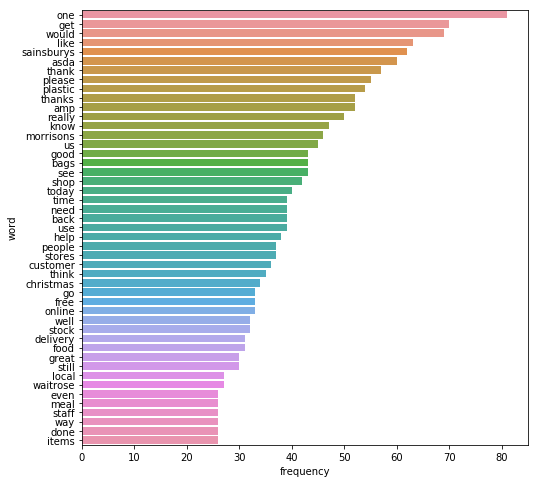

In [94]:
# visualise the top 50 most frequet words. we ignore the most frequent word 'tesco' and 'http'
# as would distort bar chart whilst adding little additional insight.
top_words = words_freq[3:50]

word = []
count = []

for i, j in top_words:
    word.append(i)
    count.append(j)
    
# adjusting figure size
plt.figure(figsize = (8,8))

# ploting a barplot of most frequency words using seaborn
sns.barplot(x = count, y = word)
plt.xlabel('frequency')
plt.ylabel('word')

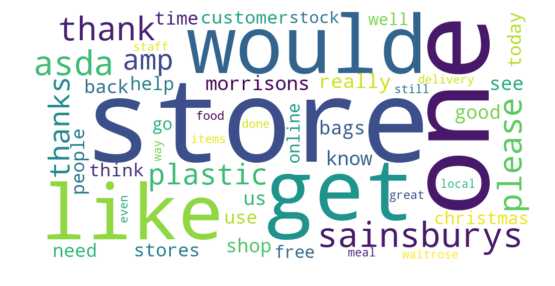

In [23]:
# We also visualise through WordCloud
words_dict = {}
for k,v in top_words:
    words_dict[k] = int(v)

# Using the WordCloud library
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate_from_frequencies(words_dict)

plt.figure(figsize=(9, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We make a couple of observations from our barplot of the top 50 terms (n_gram = 1 and 2). <br>
1) These are all n_gram = 1. Bigrams are less frequent in the corpus (as should naturally be the case)<br>
2) Adjectives that appear in the top 50 words in the corpus include: thank, good, well, great. Suggesting sentiment towards Tesco should be positive. <br>

In the steps below, we try to quantify sentiment using TextBlob and VADER.

### 4.3 Quantifying sentiment using TextBlob

We use **Textblob** to assign *sentiment polarity score* from -1 to 1 to each of our words. It then calculates the sum total sentiment polarity for each tweet by averaging the scores for the terms in the tweet in question. 

Textblob assigns sentiment scores based on pre-populated lexicon, or dictionary of words that have been previously assigned scores by humans.

We define average positive / neutral / negative sentiment for Tesco in the following way: <br>
average sentiment score >= 0.05 == positive sentiment <br>
average sentiment score > -0.05 and < 0.05 == neutral sentiment <br>
average sentiment score <= -0.05 == negative sentiment <br>

In [24]:
# create a list of sentiment scores on each of the tweets using TextBlob
sentiments = []

for tweet in tesco_tweets:
    analysis = TextBlob(tweet)
    sentiments.append(analysis.sentiment.polarity)
    
# we add this list to a new dataframe of our tweets
tesco_tweets_df = pd.DataFrame(tesco_tweets)
tesco_tweets_df['sentiments'] = sentiments
tesco_tweets_df.head()

,text,sentiments
0,bbclaurak nationalise tesco aldiuk fed always ...,0.0
1,taracartergmc morrisons tesco asda lot missing...,-0.2
2,tesco scranning lasses ars,0.0
3,dear tesco come get clubcard points booze toba...,0.0
4,tesco delivery late booked slot got one text s...,-0.3


We take a look at tweets which attained the highest/lowest sentiment scores to sense check TextBlob's labelling.

In [25]:
# find most positive tweets
positive = tesco_tweets_df.sort_values(by = 'sentiments', ascending = False)
positive = positive.reset_index(drop=True)
positive.head(5)

,text,sentiments
0,tesco hi shopping delivered would like give fe...,1.0
1,tesco mkhospital wonderful,1.0
2,jimmyicedcoffee best customer appreciation tes...,1.0
3,tesco sounds delicious,1.0
4,tesco excellent thank,1.0


In [26]:
# find most negative tweets
negative = tesco_tweets_df.sort_values(by='sentiments', ascending = True)
negative = negative.reset_index(drop=True)
negative.head(5)

,text,sentiments
0,amollygoodfella tesco nobody likes sunbites aw...,-1.0
1,well done tesco veganism way go animals planet...,-1.0
2,tesco travelers tweeted behaviour employee dis...,-1.0
3,tesco casablanca advert literally worst advert...,-1.0
4,oh tesco casablanca ad truly awful,-1.0


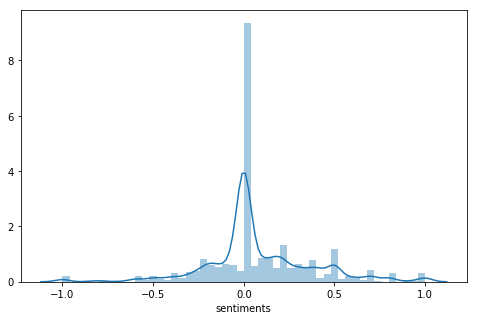

In [28]:
plt.figure(figsize = (8,5))
sns.distplot(tesco_tweets_df['sentiments'], bins = 50)

Histogram suggests distribution is more skewed to the positive end.
Below we calculate a central tendency measure (the average) of the sentiment scores for the tweets extracted.

In [53]:
average_sentiment = tesco_tweets_df[['sentiments']].mean(axis = 0)
average_sentiment

sentiments    0.080529
dtype: float64

The average sentiment score is positive (>0.05) at 0.08.
Quantifying sentiment using TextBlob also points to average positive sentiment towards Tesco.

### 4.3 Quantifying using VADER (Valence Aware Dictionary and sEntiment Reasoner)

So far we have ignored punctuations, conjunctions, emojis, emoticons when analysing text sentiment. <br>
These however, are often key in conveying emotions and sentiment. <br>
In this section, we use VADER to quantify sentiment.<br>

VADER is a lexicon and rule-based sentiment analysis tool that is specically attuned to sentiments expressed in social media.

compound score >= 0.05 == positive sentiment <br>
compound score > -0.05 and < 0.05 == neutral sentiment <br>
compound score <= -0.05 == negative sentiment

In [32]:
# We use raw tweets which includes punctuations, conjunctions, emojis, emoticons, slangs as 
# VADER analyses sentiments based on these. 
tesco_tweets_vader = tesco_df['text']

# create a list of sentiment scores on each of the tweets using .polarity_scores from VADER
sentiments_vader = []

# polarity_scores() give 4 metrics: neg, neu, pos, compound.
# pos, neg, neu scores represent the proportion of text that falls in these categories
# the compound score is a metric that calculates the sum of all the lexicon ratings which
# have been normalized between -1 and +1.
# we extract the compound score in the loop
for tweet in tesco_tweets_vader:
    analysis = analyser.polarity_scores(tweet)
    compound = list(analysis.items())[3]
    score = compound[1]
    sentiments_vader.append(score)
    
# we add this list to a new dataframe of our tweets
tesco_tweets_vader_df = pd.DataFrame(tesco_tweets_vader)
tesco_tweets_vader_df['sentiments_vader'] = sentiments_vader

In [33]:
# we test VADER's analyser.polarity with our sample_tweet
analyser.polarity_scores(sample_tweet)

{'neg': 0.076, 'neu': 0.924, 'pos': 0.0, 'compound': -0.1027}

VADER's analyser.polarity identifies the sample_tweet as 7.6% negative, 92.4% neutral and 0% positive. <br>
Equating to a compound score of -0.1027; a tweet of negative sentiment according to our definition for pos/neu/neg sentiment above.

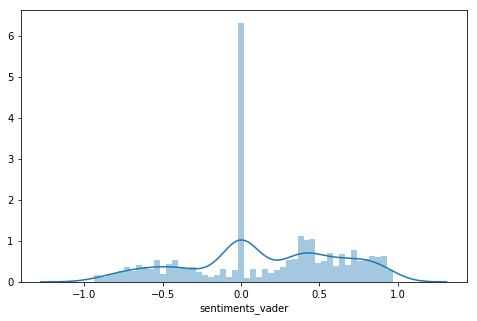

In [34]:
# we plot the VADER sentiment score distribution 
plt.figure(figsize = (8,5))
sns.distplot(tesco_tweets_vader_df['sentiments_vader'], bins = 50)

Distribution to VADER's score also seem to be skewed to the positive end.
However, unlike TextBlob's sentiment polarity scores, fewer tweets are considered 'Neutral' in sentiment. We see higher proportion of tweets distribution either in the 'positive' or 'negative' end of the spectrum.
Below we calculate a central tendency measure (the average) of the sentiment scores for the tweets extracted.

In [58]:
average_sentiment_vader = tesco_tweets_vader_df[['sentiments_vader']].mean(axis = 0)
average_sentiment_vader

sentiments_vader    0.147468
dtype: float64

We reach the same conclusion as TextBlob, that on average sentiment towards Tesco is positive.
However, individually (as suggested by histogram) the scores might be different. We take a look below.

In [35]:
# compare sentiment score assigned using VADER and using TextBlob.
for i in range(10,15):
    print("Original Text: " + tesco_tweets_vader[i])
    print("VADER score: ", tesco_tweets_vader_df.iloc[i]['sentiments_vader'])
    print("TextBlob score", tesco_tweets_df.iloc[i]['sentiments'])
    print("-------------------")

Original Text: @2Heatherb1987 @OCC_shoeboxes @Tesco @RuncornFoodbank @ksjceaided That is just fantastic xx
VADER score:  0.5574
TextBlob score 0.4
-------------------
Original Text: @Tesco Nothing from your shop
VADER score:  0.0
TextBlob score 0.0
-------------------
Original Text: @Tesco Overnight oats, easiest office job breakfast ever
VADER score:  0.4215
TextBlob score 0.0
-------------------
Original Text: Is Tesco parcel to ?? , well in hexham round up shoe boxes for a male / female  “parcels /not to food bank , but to ??? Last time I will shop @Tesco
VADER score:  0.3632
TextBlob score -0.05
-------------------
Original Text: @Tesco You are not. This picture was taken today. Totally unacceptable and unnecessary plastic packaging. Ridiculous reply.
VADER score:  -0.6997
TextBlob score -0.244444444444
-------------------


VADER and TextBlob scores don't always agree. e.g. in the third tweet above, VADER considers this positive whilst TextBlob neutral; in the 4th tweet, which reads across as negative in sentiment, VADER assigned +ve score whilst TextBlob largely neutral. 

### 4.4 [Conclusion - Data Question 1] <br>
**[Conclusion to data questions]** <br>
We assessed tweet sentiment on Tesco using three differnt methods, each concluding that on average, sentiment towards Tesco is positive. We accept our null hypothesis set out in the brief. We're unable to precisely quantify how positive the sentiment is on an absolute basis, given our quick sense check of scores assigned by TextBlob and VADER shows that TextBlob/VADER doesn't always agree with intuitive understanding of text context, likely as the algorithms are unable to deal with inflection (semantics, syntax) for example.  

**[Avenues for further study and limitations of the model]** <br>
1) We are currently using 1002 tweets for our sentiment and classification analysis (using tweets with mentionings of Tesco between 14-Nov-2019 and 15-Nov-2019. As tweets extraction is computationally expensive and takes a long time to run, we have limited our data to only 1002 tweets on tweets posted on a specific date. Though our analysis conclude that the sentiment towards Tesco is on average positive, we do not know how generally applicable this is, i.e. whether Tesco happened to have had a particularly good day on our dataset due to specific advertising campaigns. For further studies, we could run our analysis on a bigger dataset and see if there are significant differences in sentiment day on day.

## 5. [Data Question 2] - Text Classification

To answer our data question *<font color = 'brown'> ("We assess whether tweets are easily classifiable based on their sentiment. Our null hypothesis is that tweets are easily classifiable (as measured by being able to formulate a classficatio model based on sentiment able to achieve F1-score > 0.7).")* </font> , we test a range of classification models and alternative methods for word embeddings (BoW, TD-IDF, Word2Vec) and assesss the f1 score of each of the models.

Classification models are supervised learning approaches, requiring labelled data. As such we need our tweets to be labelled by sentiment. We categorize sentiment based on TextBlob sentiment scores from the previous section and use these sentiment categories to train our model. 
<font color = 'green'> *We note that this exercise could seem a bit redundant, given sentiment scores were model assigned, i.e. we could achieve 100% accuracy to use TextBlob for prediction. It would be better to have data with sentiments assigned by humans for example.*

In [36]:
# create a new column that categorises sentiment -- 'negative' if <0
#'positive' if >0 and 'neutral' if equal to 0.
tesco_tweets_df['sentiment_category'] = np.where(tesco_tweets_df['sentiments'] >0, 'positive',
                                          np.where(tesco_tweets_df['sentiments'] == 0, 'neutral', 'negative'))

In [37]:
tesco_tweets_df.head()

,text,sentiments,sentiment_category
0,bbclaurak nationalise tesco aldiuk fed always ...,0.0,neutral
1,taracartergmc morrisons tesco asda lot missing...,-0.2,negative
2,tesco scranning lasses ars,0.0,neutral
3,dear tesco come get clubcard points booze toba...,0.0,neutral
4,tesco delivery late booked slot got one text s...,-0.3,negative


### 5.1. Feature extraction -  BoW model vs. TF-IDF vs. Word2Vec

Effectiveness of text classifcation models depend on both feature extraction method and the classifer used. Below we explore a range of embedding methods and classification models.

Classification models cannot work with text directly, but take vetors of numbers as inputs. We need to convert tweets into vectors of numbers.

Two basic methods of feature extraction from text (methods of vectorization) is bag-of-words and TF-IDF

- **Bag-of-Words:**<br>
Captures basic term frequency. We looked at this briefly above when assessing overall sentiment towards Tesco. This method is based on counting how many times a given word appears in the corpus vocabulary. <br>
<br>

- **TF-IDF (Term frequency, inverse document frequency):**<br>
This can be used on top of the BoW model. Unlike BoW model, TF-IDF weighs words by how rare they are in the dataset, discounting words that are too frequent. <br>

A more advanced embedding method is Word2Vec.

- **Word2Vec**<br>
Word2Vec can capture semantic meaning of words, i.e. how close 2 words are in meaning, this is not something that is captured by BoW or TD-IDF.
Word2Vec learns from reading massive amounts of text and memorizing which words tend to appear in similar context. After being trained, it generates a 300 dimension vector for each words in a vocabulary with words of similar meaning being close to each other. <br>

We visualise the embeddings below, first of BoW, followed by TD-IDF and then Word2Vec to see if the classes look well separated. We use SVD (singular value decomposition) to reduce the dimensions of the data down to two. 

In [38]:
#########################
#Bag of Words Embeddings#
#########################

# using the train_test_split function 70/30 split
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)

In [39]:
# now we apply same feature transformation to both x_train and x_test
# we have already defined CountVectorizer above as `vector`
x_train_BoW = vector.fit_transform(x_train)
x_test_BoW = vector.fit_transform(x_test)

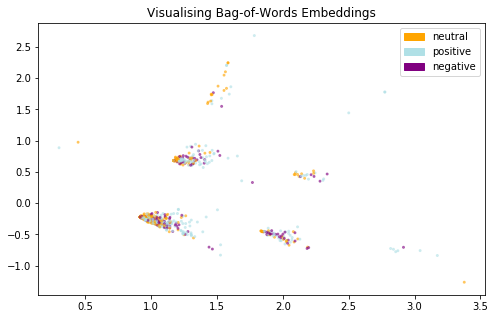

In [95]:
# visualising embeddings in 2 dimensional space.
def plot_LSA(test_data, test_labels, savepath = 'PCA_demo.csv', plot=True):
    lsa = TruncatedSVD(n_components = 2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange', 'powderblue', 'purple']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=4, alpha = .5, c=color_column, cmap=matplotlib.colors.ListedColormap(colors))
        label_1 = mpatches.Patch(color='orange', label='neutral')
        label_2 = mpatches.Patch(color='powderblue', label='positive')
        label_3 = mpatches.Patch(color='purple', label='negative')
        plt.legend(handles=[label_1, label_2, label_3], prop={'size': 10})
        
        
fit = plt.figure(figsize = (8,5))
plot_LSA(x_train_BoW, y_train)
plt.title('Visualising Bag-of-Words Embeddings')
plt.show()

The classes do not look well separated. This could be a feature of the embeddings or of the dimensionality reduction. We also take a look at TF-IDF and Word2Vec embeddings below.

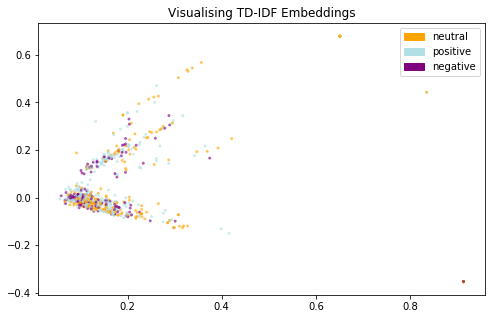

In [96]:
###################
#TF-IDF Embeddings#
###################

# vectorise using TfidfVectorizer()
vector_Tfidf = TfidfVectorizer(max_features = 10000, min_df = 0.005)
# now we apply same feature transformation to both x_train and x_test
x_train_Tfidf = vector_Tfidf.fit_transform(x_train)
x_test_Tfidf = vector_Tfidf.fit_transform(x_test)

# visualise
fit = plt.figure(figsize = (8,5))
plot_LSA(x_train_Tfidf, y_train)
plt.title('Visualising TD-IDF Embeddings')
plt.show()

In [75]:
#####################
#Word2Vec Embeddings#
#####################

# we downloaded a large corpus on which the model was pre-trained.
word2vec_path = "GoogleNews-vectors-negative300.bin"

# we limit to 700000 to save on RAM and computing power
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit = 700000)

In [77]:
tesco_tweets_df['tokens'] = tesco_tweets_df['text'].apply(lambda x: word_tokenize(x))

In [79]:
def get_average_word2vec(tokens_list, vector, generate_missing = False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis = 0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, tweets_df, generate_missing = False):
    embeddings = tweets_df['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing = generate_missing))
    return list(embeddings)


In [80]:
embeddings = get_word2vec_embeddings(word2vec, tesco_tweets_df)

In [81]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, tesco_tweets_df['sentiment_category'], 
                                                                                        test_size = 0.3, random_state = 123)

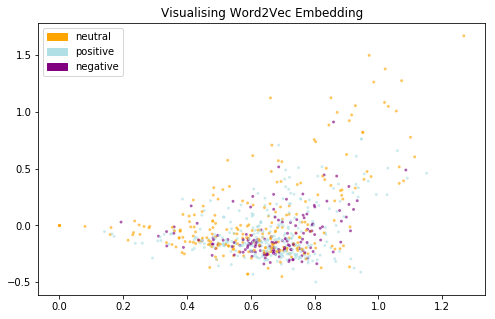

In [99]:
# a visualisation of our new embedding
fig = plt.figure(figsize = (8,5))
plot_LSA(X_train_word2vec, y_train_word2vec)
plt.title('Visualising Word2Vec Embedding')
plt.show()

Visually we see improvement in separation between classes in TF-IDF and Word2Vec compared to the simple Bag-of-Words embeddings. However, it's unclear whether classes are more separated under TF-IDF or Word2Vec.

Therefore below, we assess a range of classifier models using both TF-IDF and Word2Vec embeddings to answer our data question.

### 5.2 Classifiers

In [159]:
#########################
#Naive-Bayes with TF-IDF#
#########################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.491694352159
             precision    recall  f1-score   support

   negative       1.00      0.06      0.12        80
    neutral       0.74      0.34      0.47       109
   positive       0.43      0.95      0.59       112

avg / total       0.69      0.49      0.42       301



In [93]:
###########################
#Decision Tree with TF-IDF#
###########################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', tree.DecisionTreeClassifier(random_state = 123)),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.56146179402
             precision    recall  f1-score   support

   negative       0.56      0.30      0.39        80
    neutral       0.52      0.76      0.62       109
   positive       0.63      0.55      0.59       112

avg / total       0.57      0.56      0.55       301



In [155]:
#############################
#Decision Tree with Word2Vec#
#############################

model = tree.DecisionTreeClassifier(random_state = 123)
model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)
print('accuracy %s' % accuracy_score(y_test_word2vec, y_pred))
print(classification_report(y_test_word2vec, y_pred))

accuracy 0.498338870432
             precision    recall  f1-score   support

   negative       0.43      0.44      0.43        80
    neutral       0.55      0.50      0.53       109
   positive       0.50      0.54      0.52       112

avg / total       0.50      0.50      0.50       301



In [94]:
###########################
#Random Forest with TF-IDF#
###########################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(random_state=123)),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.627906976744
             precision    recall  f1-score   support

   negative       0.79      0.24      0.37        80
    neutral       0.58      0.90      0.71       109
   positive       0.67      0.64      0.65       112

avg / total       0.67      0.63      0.60       301



In [160]:
############################
#RandomForest with Word2Vec#
############################

model = RandomForestClassifier(random_state=123)
model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)
print('accuracy %s' % accuracy_score(y_test_word2vec, y_pred))
print(classification_report(y_test_word2vec, y_pred))

accuracy 0.485049833887
             precision    recall  f1-score   support

   negative       0.42      0.35      0.38        80
    neutral       0.55      0.57      0.56       109
   positive       0.46      0.50      0.48       112

avg / total       0.48      0.49      0.48       301



In [95]:
#####################
#Bagging with TF-IDF#
#####################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', BaggingClassifier(tree.DecisionTreeClassifier(random_state=123))),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.611295681063
             precision    recall  f1-score   support

   negative       0.66      0.34      0.45        80
    neutral       0.56      0.79      0.66       109
   positive       0.66      0.63      0.65       112

avg / total       0.63      0.61      0.60       301



In [161]:
##################################
#Bagging with Word2Vec Embeddings#
##################################

model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=123))
model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)
print('accuracy %s' % accuracy_score(y_test_word2vec, y_pred))
print(classification_report(y_test_word2vec, y_pred))

accuracy 0.554817275748
             precision    recall  f1-score   support

   negative       0.51      0.31      0.39        80
    neutral       0.59      0.59      0.59       109
   positive       0.55      0.70      0.61       112

avg / total       0.55      0.55      0.54       301



In [96]:
######################
#Boosting with TF-IDF#
######################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', GradientBoostingClassifier(random_state=123)),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.654485049834
             precision    recall  f1-score   support

   negative       0.78      0.31      0.45        80
    neutral       0.61      0.89      0.72       109
   positive       0.69      0.67      0.68       112

avg / total       0.68      0.65      0.63       301



In [97]:
########################
#Linear SVM with TF-IDF#
########################
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state = 123, max_iter=5, tol=None)),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.641196013289
             precision    recall  f1-score   support

   negative       0.70      0.38      0.49        80
    neutral       0.64      0.72      0.68       109
   positive       0.62      0.75      0.68       112

avg / total       0.65      0.64      0.63       301



In [156]:
##############################
#SVM with Word2Vec Embeddings#
##############################

model = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state = 123, max_iter=5, tol=None)
model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)
print('accuracy %s' % accuracy_score(y_test_word2vec, y_pred))
print(classification_report(y_test_word2vec, y_pred))

accuracy 0.65780730897
             precision    recall  f1-score   support

   negative       0.63      0.45      0.53        80
    neutral       0.69      0.79      0.74       109
   positive       0.64      0.68      0.66       112

avg / total       0.65      0.66      0.65       301



In [73]:
#################################
#Logistic Regression with TF-IDF#
#################################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(C=1e5, random_state=123)),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.634551495017
             precision    recall  f1-score   support

   negative       0.67      0.39      0.49        80
    neutral       0.65      0.71      0.68       109
   positive       0.61      0.74      0.67       112

avg / total       0.64      0.63      0.62       301



In [162]:
###################################
#Logistic Regression with Word2Vec#
###################################

model = LogisticRegression(C=1e5, random_state=123)
model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)
print('accuracy %s' % accuracy_score(y_test_word2vec, y_pred))
print(classification_report(y_test_word2vec, y_pred))

accuracy 0.518272425249
             precision    recall  f1-score   support

   negative       0.42      0.42      0.42        80
    neutral       0.56      0.48      0.51       109
   positive       0.55      0.62      0.58       112

avg / total       0.52      0.52      0.52       301



In [164]:
#################
#KNN with TF-IDF#
#################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', KNeighborsClassifier()),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.541528239203
             precision    recall  f1-score   support

   negative       0.66      0.49      0.56        80
    neutral       0.50      0.64      0.56       109
   positive       0.53      0.48      0.50       112

avg / total       0.55      0.54      0.54       301



In [165]:
###################
#KNN with Word2Vec#
###################

model = KNeighborsClassifier()
model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)
print('accuracy %s' % accuracy_score(y_test_word2vec, y_pred))
print(classification_report(y_test_word2vec, y_pred))

accuracy 0.514950166113
             precision    recall  f1-score   support

   negative       0.42      0.31      0.36        80
    neutral       0.72      0.39      0.51       109
   positive       0.48      0.78      0.59       112

avg / total       0.55      0.51      0.50       301



In [100]:
#####################
#Rocchio with TF-IDF#
#####################

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', NearestCentroid()),
              ])
x_train, x_test, y_train, y_test = train_test_split(tesco_tweets_df['text'], 
                                                   tesco_tweets_df['sentiment_category'],
                                                   test_size = 0.3, random_state = 123)
nb.fit(x_train, y_train)

y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.644518272425
             precision    recall  f1-score   support

   negative       0.68      0.56      0.62        80
    neutral       0.62      0.71      0.66       109
   positive       0.65      0.64      0.65       112

avg / total       0.65      0.64      0.64       301



In [166]:
#######################
#Rocchio with Word2Vec#
#######################

model = NearestCentroid()
model.fit(X_train_word2vec, y_train_word2vec)
y_pred = model.predict(X_test_word2vec)
print('accuracy %s' % accuracy_score(y_test_word2vec, y_pred))
print(classification_report(y_test_word2vec, y_pred))

accuracy 0.544850498339
             precision    recall  f1-score   support

   negative       0.48      0.72      0.58        80
    neutral       0.57      0.58      0.58       109
   positive       0.61      0.38      0.47       112

avg / total       0.56      0.54      0.54       301



### 5.4 [Conclusion - Data Question 2]

**[Conclusion to data questions]** <br>
Our Rocchio with TF-IDF embeddings classification model yielded the highest F1-score at 0.62 (this is lower than the threshold we set out in our brief of 0.7). Our SVM with Word2Vec embeddings classication model yielded the highest accuracy score of 0.66 (this is also lower than the threshold we set out in our brief of 0.7). We conclude that tweets are not easily classifiable based on sentiment.


**[Avenues for further study and limitations of the model]** <br>
1) Interestingly, classfication models using Word2Vec performs worse than TD-IDF, despite intuitively, Word2Vec takes into account of semantics whilst TF-IDF embeddings doesn't and so should perform better. This could be cause our dataset is relatively small with only 444 unique words and Word2Vec won't be able to capture word relationship in the embedding space with limited information. 
2) To improve our analysis we should look at more data we may also try to fine-tune the hyperparameters of our classification models to see if we could improve on model accuracy and F1-score.
